In [1]:
import pandas as pd
import numpy as np

dados = pd.read_csv('../dados/CSV_Completo.csv')

animal = 'É animal mais atropelado'
animalEscolhido = 'rã-manteiga'

dados.loc[dados.Animal == animalEscolhido,animal] = 1
dados.loc[dados.Animal != animalEscolhido,animal] = 0


dados[animal] = dados[animal].astype(int)
 

In [2]:
del(dados['Animal'])
del(dados['Km'])
del(dados['Hora da Coleta'])
del(dados['Local'])
del(dados['Tipo De Pistas'])

In [3]:
y = dados.pop(animal)
X = dados
# print(X)

In [4]:
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

d = defaultdict(LabelEncoder)
# Encoding the variable
X_encoded = X.apply(lambda x: d[x.name].fit_transform(x))


In [5]:
from sklearn.feature_selection import SelectKBest, chi2

features = []

for i in X_encoded:
    features.append(i)

k = 10 # seleciona 10 features

sel_chi2 = SelectKBest(chi2, k = 10)
X_train_novo = sel_chi2.fit_transform(X_encoded, y)

print("os atributos escolhidos foram:")
atributosSelect = []
for j in sel_chi2.get_support(indices=True):
    atributosSelect.append(features[j])
    
print(atributosSelect)

colums = ["target"]
col2 = []
for i in range(k):
    colums.append(i)
    col2.append(i)

print(X_train_novo.shape)

novoDf = pd.DataFrame(X_train_novo, y).reset_index()
novoDf.columns = [colums]

novoX = novoDf[col2]
novoY = novoDf["target"]

os atributos escolhidos foram:
['Mês', 'Estação', 'Trecho', 'Sentido', 'Trecho macro', 'Numero de Pistas', 'Numero de Faixas', 'Velocidade Maxima', 'Floresta', 'Faixa de Quilometragem']
(13096, 10)


In [6]:
# Inverse the encoded
X_decoded = X_encoded.apply(lambda x: d[x.name].inverse_transform(x))
# print(X_decoded)
dados_filtrados = pd.DataFrame()

for i in atributosSelect:
    dados_filtrados[i] = X_decoded[i]
    
dados_filtrados[animal] = y

In [7]:
dadosEncod = pd.get_dummies(dados_filtrados)

# dadosEncod['target'] = y

dummies_names = []

x_codificado = dadosEncod

for i in x_codificado:
    dummies_names.append(i)
    # print(i)
    
dummies_names.remove(animal)

print(dummies_names)

['Mês', 'Trecho', 'Estação_Inverno', 'Estação_Outono', 'Estação_Primavera', 'Estação_Verão', 'Sentido_JF', 'Sentido_RJ', 'Trecho macro_Baixada', 'Trecho macro_Planalto', 'Trecho macro_Serra', 'Numero de Pistas_0', 'Numero de Pistas_1', 'Numero de Pistas_2', 'Numero de Pistas_3', 'Numero de Pistas_4', 'Numero de Pistas_5', 'Numero de Pistas_6', 'Numero de Pistas_Desconhecido', 'Numero de Faixas_0', 'Numero de Faixas_1', 'Numero de Faixas_2', 'Numero de Faixas_3', 'Numero de Faixas_4', 'Numero de Faixas_5', 'Numero de Faixas_6', 'Numero de Faixas_7', 'Numero de Faixas_8', 'Numero de Faixas_9', 'Numero de Faixas_Desconhecido', 'Velocidade Maxima_0', 'Velocidade Maxima_100', 'Velocidade Maxima_11', 'Velocidade Maxima_110', 'Velocidade Maxima_119', 'Velocidade Maxima_20', 'Velocidade Maxima_30', 'Velocidade Maxima_40', 'Velocidade Maxima_50', 'Velocidade Maxima_60', 'Velocidade Maxima_70', 'Velocidade Maxima_72', 'Velocidade Maxima_80', 'Velocidade Maxima_90', 'Velocidade Maxima_Desconhecid

<BarContainer object of 2 artists>

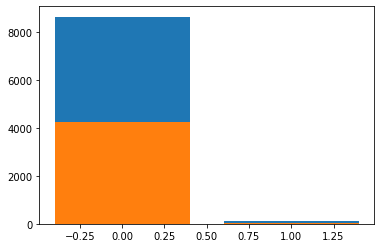

In [8]:
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

dadosTreino, dadosTeste = train_test_split(dadosEncod, test_size = 0.33, random_state = 0)

# countTreino = dadosTreino[animal].value_counts()
# countTeste = dadosTeste[animal].value_counts()

countTreino = dadosTreino[animal].value_counts()
countTeste = dadosTeste[animal].value_counts()
plt.bar([0, 1], countTreino) 
plt.bar([0, 1], countTeste) 



In [9]:
treino_y = dadosTreino.pop(animal)
treino_x = dadosTreino

teste_y = dadosTeste.pop(animal)
teste_x = dadosTeste

Balanceamento:

In [10]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(treino_x, treino_y)

O classificador é inicializado com max depth = 3 e random state = 20. O argumento max depth controla a profundidade máxima da árvore

In [11]:
from sklearn.tree import DecisionTreeClassifier

modelo = DecisionTreeClassifier(max_depth=4)
modelo.fit(X_res, y_res)
previsoes = modelo.predict(teste_x)


In [17]:
from sklearn import tree
from sklearn.tree import export_text
import graphviz

# figura, eixos = plt.subplots(nrows=1,ncols=1,figsize=(300,300))
# tree.plot_tree(modelo, feature_names=dummies_names, filled = True)

false = "não é " + animalEscolhido
true = "é " + animalEscolhido

targets = {0: false, 1: true}

dot_data = tree.export_graphviz(modelo, out_file=None,
                         feature_names=dummies_names,
                         class_names=targets,
                         filled=True, rounded=True,
                         special_characters=True, leaves_parallel=True)
graph = graphviz.Source(dot_data)
graph.render(animalEscolhido)

r = export_text(modelo, feature_names=dummies_names)
print(r)

|--- Estação_Primavera <= 0.50
|   |--- Mês <= 2.50
|   |   |--- Floresta_sim <= 0.50
|   |   |   |--- Velocidade Maxima_90 <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- Velocidade Maxima_90 >  0.50
|   |   |   |   |--- class: 0
|   |   |--- Floresta_sim >  0.50
|   |   |   |--- Trecho <= 3.50
|   |   |   |   |--- class: 1
|   |   |   |--- Trecho >  3.50
|   |   |   |   |--- class: 0
|   |--- Mês >  2.50
|   |   |--- Mês <= 8.50
|   |   |   |--- Mês <= 4.50
|   |   |   |   |--- class: 0
|   |   |   |--- Mês >  4.50
|   |   |   |   |--- class: 0
|   |   |--- Mês >  8.50
|   |   |   |--- Estação_Inverno <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- Estação_Inverno >  0.50
|   |   |   |   |--- class: 0
|--- Estação_Primavera >  0.50
|   |--- Numero de Pistas_1 <= 0.50
|   |   |--- Velocidade Maxima_90 <= 0.50
|   |   |   |--- Floresta_sim <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- Floresta_sim >  0.50
|   |   |   |   |--- class: 0
|   |   |--- Velocidade Maxi

              precision    recall  f1-score   support

           0       1.00      0.74      0.85      4270
           1       0.03      0.71      0.06        52

    accuracy                           0.74      4322
   macro avg       0.51      0.72      0.45      4322
weighted avg       0.98      0.74      0.84      4322

Matriz de confusão


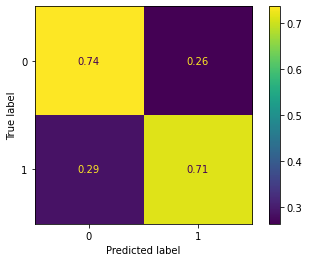

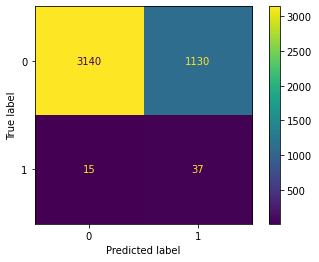

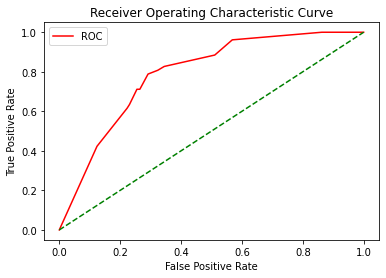

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

print(classification_report(teste_y, previsoes, zero_division=0))

print("Matriz de confusão")
matriz_confusaoPorc = confusion_matrix(teste_y, previsoes, normalize = 'true')
matrizPorc = ConfusionMatrixDisplay(matriz_confusaoPorc)
matrizPorc.plot()

matriz_confusao = confusion_matrix(teste_y, previsoes)
matriz = ConfusionMatrixDisplay(matriz_confusao)
matriz.plot()
plt.show()

def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
    
from sklearn.metrics import roc_curve

TargetVarScore = modelo.predict_proba(teste_x)
fper, tper, thresholds = roc_curve(teste_y, TargetVarScore[:, 1])
plot_roc_curve(fper, tper)

Obtendo regras de forma mais legível

In [19]:
from sklearn.tree import _tree

def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

In [20]:
rules = get_rules(modelo, dummies_names, targets)

# > 0.5 = true
# <= 0.5 = false

for r in rules:
    str(r)
    new_r = r.replace('> 0.5', "= true").replace('<= 0.5', "= false")
    print(new_r)

if (Estação_Primavera = true) and (Numero de Pistas_1 = false) and (Velocidade Maxima_90 = false) and (Floresta_sim = false) then class: é rã-manteiga (proba: 82.3%) | based on 6,519 samples
if (Estação_Primavera = false) and (Mês <= 2.5) and (Floresta_sim = false) and (Velocidade Maxima_90 = false) then class: é rã-manteiga (proba: 73.19%) | based on 3,130 samples
if (Estação_Primavera = false) and (Mês > 2.5) and (Mês <= 8.5) and (Mês > 4.5) then class: não é rã-manteiga (proba: 99.01%) | based on 2,628 samples
if (Estação_Primavera = false) and (Mês > 2.5) and (Mês <= 8.5) and (Mês <= 4.5) then class: não é rã-manteiga (proba: 90.53%) | based on 1,531 samples
if (Estação_Primavera = false) and (Mês > 2.5) and (Mês > 8.5) and (Estação_Inverno = true) then class: não é rã-manteiga (proba: 94.4%) | based on 536 samples
if (Estação_Primavera = true) and (Numero de Pistas_1 = true) and (Trecho > 3.5) then class: não é rã-manteiga (proba: 100.0%) | based on 513 samples
if (Estação_Primave